# Data Processing Functions

### Data notice: 
The csv is a sample which was manually generated. 
All columns except for "gender" and "specialization" are available from Dimensions Dimcli -- as explained in [Examples](#Examples) Section. 

The gender values were manually entered and the specializations were randomly generated from four types common in AI in Healthcare. 

For real usage, genderize.io or gender_detector may be useful.  
For specialization web-scraping will be required. 

Otherwise manually generating a test csv file will always work if your scale is small

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
_df = pd.read_csv("sampleTableV3.csv") # read csv file as dataframe

In [3]:
_df.head()

,pub_id,first_name,last_name,aff_country,aff_country_code,aff_id,aff_city,aff_city_id,gender,specialization
0,pub.1123345821,Adam,Smith,Italy,IT,64563,Rome,92341,male,Healthcare
1,pub.1123345821,Emily,Johnson,Cuba,CU,72490,Havana,90182,female,Computer Science
2,pub.1123345821,Robert,Brown,United States,US,21345,New York City,45378,male,Engineering
3,pub.1123345821,Maria,Garcia,Mexico,MX,56733,Mexico City,41414,female,Social Science
4,pub.1123345821,David,Williams,United States,US,21345,New York City,45378,male,Healthcare


In [4]:
class Author(object):
    def __init__(self, paper, first, last, country, country_code, aff_city, gender, specialization): 
        self.firstName = first 
        self.lastName = last 
        self.country = country
        self.country_code = country_code
        self.city = aff_city 
        self.gender = gender
        self.paperList = []
        self.specialization = specialization
        self.paperList.append(paper) 

    def __eq__(self, other):
        if (isinstance(other, Author)): 
            return (self.firstName == other.firstName and 
                    self.lastName == other.lastName and 
                    self.gender == other.gender and 
                    self.country_code == other.country_code and 
                    self.specialization == other.specialization)
        else: 
            return False 

    def __hash__(self):
        return(hash(self.firstName + self.lastName))

    def display(self): 
        print("Author: {} {} from {}, {} ({}, {})".format(self.firstName, 
                                                          self.lastName, 
                                                          self.city, 
                                                          self.country, 
                                                          self.gender, 
                                                          self.specialization))
    
    def getName(self):
        return self.firstName + " " + self.lastName 
      

In [5]:
def collectAuthorsOfOnePaper(df, pub_id, start_point=0, **kwargs):
    refAuthor = kwargs.get('refAuthor', None)
    authorList = []
    for index, row in df[start_point:].iterrows(): 
        if (row["pub_id"] == pub_id): 
            author = Author(
                row["pub_id"], 
                row["first_name"], 
                row["last_name"],
                row["aff_country"], 
                row["aff_country_code"], 
                row["aff_city"], 
                row["gender"], 
                row["specialization"]
            )
            if (author != refAuthor):
                authorList.append(author)
        else:
            if (start_point != 0):
                break
    return authorList

In [6]:
# Function will search dataframe for the specific author object entered. Identified through first and last name property. 
# Use collectAuthorsOfOnePaper method to create this list 

def searchAuthorPapers(df, author):
    paperDict = {} # Dictionary of an author's papers. Each key is a publication ID, each value is a list of collaborators for that paper  
    collectionStartPoint = -1 # Tells which row the publication ID begins in df.
    previousPaperID = "" # Notifies when the publication changes -- Updates collectionStartPoint
    for index, row in df.iterrows():
        if(row["pub_id"] != previousPaperID):
            previousPaperID = row["pub_id"]
            collectionStartPoint = index
        if row['first_name'] == author.firstName and row['last_name'] == author.lastName and row['aff_country'] == author.country:
            pub_id = row['pub_id'] # key
            authorList = collectAuthorsOfOnePaper(df, pub_id, collectionStartPoint, refAuthor=author) # adds all collaborators (discludes target author)
            pub_id = pub_id.replace("pub.", "")
            pub_id = int(pub_id)
            paperDict[pub_id] = authorList
    return paperDict

In [7]:
# Visualizations of dictionary using graph
import matplotlib.pyplot as plt
import networkx as nx

In [8]:
def create_graph(dict_x):
    G = nx.from_dict_of_lists(dict_x)
    return G

In [9]:
def show_graph(G): 
    labelDict = {}
    for node in G.nodes:
        if(isinstance(node, Author)):
            labelDict[node] = node.getName()
        else:
            labelDict[node] = node
    nx.draw_spring(G, labels=labelDict)
    plt.show()

# Determining the index... 

## Paper-based features

**Relative Diversity** <br> 
This index hinges on the idea of relative diversity. Given a reference author with n-features, we compare this author to a collaborator with n-features. The more different the reference author is relative to their collaborators, the greater their d-index. 
The actual calculation simply takes the process feature by feature. <br>
For any feature "x" there is a proportion of collaborators that share the same feature with the reference author. 
By taking the reciprocal of this proportion we can get the value of the author's representation of that feature. <br>
<br>
Example: feature=gender, n-authors=4 <br>
If there are two male authors and two female authors each gender makes up 1/2 of the paper. The reciprocal of which is 2. Since both share the same reciprocal they are all given the same weightage. <br>
<br>
Example: feature=gender, n-authors=4 <br>
If there are three male authors and one female author then each gender makes up different proprtions -- males make up 3/4 and females make up 1/4. Taking the reciprocal the female gets a weightage of 4, and the males get a factor of 1.33, which rounds to 1. <br>
<br>
Essentially, relative diversity puts people in positions to work with people who have different features than them, as it maximizes their weightage or value (quantifying human value is difficult, but neccessary for competition) in a given paper. 

What this essentially does is tries to boost a features value to be equal. So the more unique your feature, the greater your factor. 

**Features supported:**
- Gender
- Nationality
- Specialization (Discipline)

Note that all features may not be neccessary... and a big part of the discussion is which features to include

Another important thing to note is the relative value of features. We handle this by giving each feature a "baseFactor" 
By default a feature's baseFactor is 1, and so all features are accounted for equally. 

Essentially you take the baseFactor of a feature and multiply it by the weightage (relative diversity proportion) to get the resulting featureFactor. 

By modifying the baseFactor you can start to get feature weightage as well.
Ex: Giving gender a baseFactor of 2 and specialization a baseFactor of 4. Now specialization is twice as important. 

### Binary vs. Categorical features 
A common distinction between features is that some are binary (i.e. gender) and others are categorical (i.e. nationality). 
To handle binary features the proportions are quite simple, as you can directly check for which people are not like the reference author. 

To handle categorical features a dictionary is set up for each paper. 
Every unique categorical feature is a key, and the number of authors with that feature (count) is the value. 

Currently this is handled similar to binary features in that we just use it for simply calculating relative diversity proportion. 

However, in some cases it may be neccessary to weight certain categories a feature may contain. 
For example, in the case of nationality it is very easy for English-native speakers to work with other countries, but much harder for other countries. In this case having some kind of category weight may be useful, perhaps based on the [EF English Proficency Index](https://www.ef.com/wwen/epi/)

To implement this we use a dictionary of dictionaries. Essentially for each feature you can add another dictionary which maps categories to relative weightages. The weightage system is slightly counterintutive. Instead of giving a weightage of 1/2 to a group you want to give less value towards, you really want to give it a value of 2. This is because of the reciprocal. Storing the counts in a dictionary and then taking the reciprocal of that we want categories different from the reference author to actually be valued more in order to make the reciprocal greater. In order to make it more inuitive, the categorical function takes the reciprocal of whatever ratio you want to use by default. You can disable this if you like. 

## Cross-paper features
**n times collaborated with** <br>
Each paper appearance will cause the affect of their appearance to decrease by __x% across all papers every n shared appearances__ <br>
The primary reason for this is to avoid "cheating" the index. 

While **relative diversity** is useful in getting people to work with people unlike them, it does not stop them from working with the **same** people unlike them. 

The aim of the index is to encourage new collaboration so therefore we add a cost for a certain amount of times the author appears. 
Essentially this creates an exponential decay function where the authors contribution, c, is multiplied by some proportion, n/d (d>n), raised to the power of (xPublications/nRepeats) or more simply: 

c(n/d)^(xPublications/nRepeats) where xPublications/nRepeats is floored. 

The nRepeats is to avoid being too punishing as many topics are covered over many papers, so it makes sense for authors to appear multiple times in some cases, while still preventing heavily cheating the index. 

## Result
- Sucessfully calculate the relative-diversity of each feature of a referenceAuthor to their collaborators in a single paper.
- Sucessfully prevent cheating the index by using the **same** relatively diverse group of people
- Sucessfully make an extensive system for both binary and categorical features
- Provide both feature weightage (base factors) and categorical weightage
 
## Future paper-based features
 - University Ranking

## Future cross-paper features 
 - None

## Supplemental calculation functions
These functions are repeated actions used in the calculation.

Note: \
The binaryCalculation() function and categoricalCalculation() function still do essentially the same thing. \
Only keeping track of unique values in a dictionary in case we would like to do unique things for unique features. \
\
Example: \
If someone comes from an English native speaking country, then maybe lower their contribution to the nationality bonus. 
Allows us to give recognition to those who have to learn English to contribute (higher barrier to entry)

Any categorical feature can be a binary feature. \
Just check for "same as refAuthor", or "different from refAuthor"

In [10]:
# Applies the cost to the value an n number of times (currently n is a proportion) 
# This will allow us to give custom costss to features that maybe require different rules. 
def costApplication(proportion, cost):
    return (cost**(round(proportion)))

In [11]:
# Gets the reciprocal
def getReciprocal(n, d): 
    if n != 0: 
        return round(1/(n/d)) 
    else: 
        return 0

In [12]:
# Calulating the factor for a binary feature (i.e. gender) 
def binaryCalculation(refAuthorFeature, collabFeature, baseFactor):
    if refAuthorFeature == collabFeature: 
        return baseFactor
    else:
        return 0

In [13]:
# Calculating the factor for a categorical feature (more than two types) 
# Automatically updates the dictionary, do not need to sum
def categoricalCalculation(collabCategory, baseFactor, countDict, featureName, categoricalWeights, **kwargs): 
    defaultReciprocal = kwargs.get('defaultReciprocal', True)
    if categoricalWeights is not None:
        weightedCategories = {j for i in categoricalWeights.values() for j in i}
        weightedCategories = list(weightedCategories)
        if collabCategory in weightedCategories: 
            if defaultReciprocal is True: 
                baseFactor = baseFactor * (1/categoricalWeights[featureName][collabCategory])
            else:
                baseFactor = baseFactor * categoricalWeights[featureName][collabCategory]
        else:
            baseFactor = 1 * baseFactor
    
    #print(baseFactor)
    if collabCategory not in countDict.keys():
        countDict[collabCategory] = baseFactor
    else: 
        countDict[collabCategory] += baseFactor

In [14]:
def calculateDIndex(author, collabDict, collabGraph, minRepeats = 3, repeatCost = 0.2, **kwargs):
    # Set up optional arguments
    crossPaper = kwargs.get('crossPaper', True) # To compare index calculation with and without consideration for repeating authors
    print_factors = kwargs.get('print_factors', False) # To trace math calculations
    
    # Customizing the base factors will allow us to set relative weightages for each feature
    # by default they are all 1, giving the same weight to all features
    baseGenderFactor = kwargs.get('baseGenderFactor', 1) 
    baseNationalityBonus = kwargs.get('baseNationalityBonus', 1) 
    baseSpecializationFactor = kwargs.get('baseSpecializationFactor', 1)

    categoricalWeights = kwargs.get('categoricalWeights', None)
    defaultReciprocal = kwargs.get('defaultReciprocal', True)
    
    # Storage for index of each paper
    paperFeatureIndices = []
    for publication in collabDict.keys():
        # Setup features for original author
        genderFactor = 1 * baseGenderFactor
        nationalityBonus = 0
        nationalityCounts = {author.country_code : 1 * baseNationalityBonus}
        specializationFactor = 0
        specializationCounts = {author.specialization : 1 * baseSpecializationFactor}
        
        for collab in collabDict[publication]:
            # Access collaborator features
            cost = 1 #reset cost
            repeatProportion = collabGraph.degree[collab]/minRepeats 
            # Cost creation condition
            if collabGraph.degree[collab] >=  minRepeats and crossPaper == True: 
                cost = (1 - repeatCost)
            
            # Gender calculation for this collaborator-- do they share this feature?
            genderFactor += binaryCalculation(author.gender, collab.gender, baseGenderFactor)*costApplication(repeatProportion, cost)
            # Country_code calculation
            categoricalCalculation(collab.country_code, 
                                   baseNationalityBonus*costApplication(repeatProportion, cost), 
                                   nationalityCounts, 
                                   "nationality", 
                                   categoricalWeights, 
                                   defaultReciprocal=defaultReciprocal
                                  )   

            # Specialization Calculation
            categoricalCalculation(collab.specialization, 
                                   baseSpecializationFactor*costApplication(repeatProportion, cost), 
                                   specializationCounts,
                                   "specialization", 
                                   categoricalWeights, 
                                   defaultReciprocal=defaultReciprocal
                                  )
        
        # find feature-values for this publication
        genderFactor = getReciprocal(genderFactor, len(collabDict[publication]))
        
        nationality_weight = getReciprocal(nationalityCounts[author.country_code], sum(nationalityCounts.values())) 
        nationalityBonus += len(set(nationalityCounts.keys()))*nationality_weight

        specialization_weight = getReciprocal(specializationCounts[author.specialization], len(collabDict[publication]))
        specializationFactor += len(set(specializationCounts.keys()))*specialization_weight
        
        # prints the feature-values for this individual paper
        if print_factors == True:
            print("pub." + str(publication))
            print("Gender Factor: " + str(genderFactor))
            print("Nationality Factor: " + str(nationalityBonus))
            print("Specialization Factor: " + str(specializationFactor)) 
        
        # The paper index is the sum of the feature-values
        paperFeatureIndices.append(genderFactor + nationalityBonus + specializationFactor)
    
    #Final calculation is just the average of paper indeices
    return round(sum(paperFeatureIndices)/len(paperFeatureIndices))

In [15]:
def show_author_publications(dict_x, G):
    count = 0
    keys = dict_x.keys()
    for publication in keys:
        print("pub." + str(publication))
        for author in dict_x[publication]: 
            author.display()
            print("Number of shared occurences: " + str(G.degree[author]))
        count+=1
        print()

# Examples (Revised - 9/28/24) 

1) Binary Feature Example
2) Categorical Feature Example
3) Cross Paper Example

Notice: 
Examples are drawn from a sample csv file, which models its columns after collected data from the Dimensions database. Information extracted from the database should consist of these columns.

After extracting data from Dimensions you must apply this function to the output: 
.as_dataframe_authors_affiliations() <br>
Further documentation linked here: 
[Dimcli Docs](https://api-lab.dimensions.ai/cookbooks/7-researchers/Researchers-Search-tips-V2.html )

The sample csv mimics the output, but does not use real researchers. 
We compiled a dataframe consisting of many television characters, using actors working in multiple shows as cross-paper authors, along with mixing up some actors to generate our examples.

### This is just a conceptual demonstration of the potential for a d-index to encourage new collaboration new research. By no means is this conclusive or final. New ideas and features will have to be considered prior to real implementation

## Binary Feature Examples : 
Here we analyze only the gender feature. Aiming to display the fundamental idea of relative diversity and its effect 
on a reference author's d-index

In [16]:
# Initialize Author List
authors = collectAuthorsOfOnePaper(_df, "pub.0941530802")

for author in authors: 
    author.display()

Author: Omar Hassan from Jerusalem, Palestine (male, Engineering)
Author: Daniel Young from Atlanta, United States (male, Social Science)
Author: Joshua Carter from Rome, Italy (male, Healthcare)
Author: Anna Nguyen from Los Angeles, United States (female, Computer Science)


In [17]:
# 3 males, 1 female
referenceAuthor1 = authors[0]
referenceAuthor1_papers = searchAuthorPapers(_df, referenceAuthor1) 
referenceAuthor1_graph = create_graph(referenceAuthor1_papers)

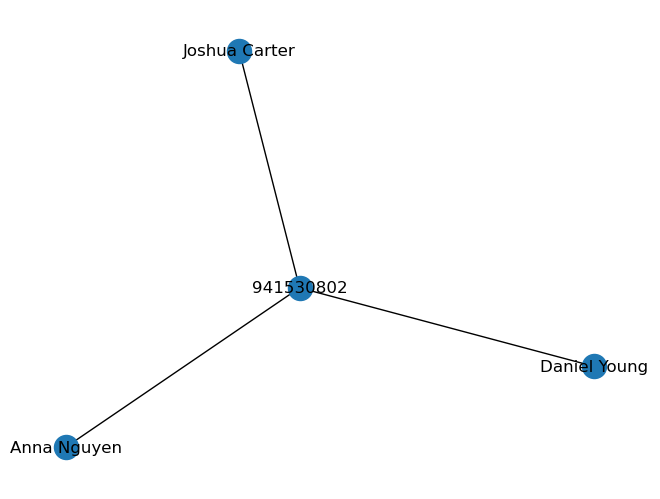

In [18]:
show_graph(referenceAuthor1_graph)

In [19]:
# referenceAuthor1 is only a part of one paper, and has 3 collaborators. 
# Calculate only Gender Factor of D-index
calculateDIndex(referenceAuthor1, 
                referenceAuthor1_papers, 
                referenceAuthor1_graph, 
                baseNationalityBonus=0, 
                baseSpecializationFactor=0,
                print_factors=True
               )

pub.941530802
Gender Factor: 1
Nationality Factor: 0
Specialization Factor: 0


1

In [20]:
# His d-index is only 1 which makes sense only applying the gender factor. 
# 3/4 Are males, reciprocal is 4/3 rounds to gender factor of 1. 

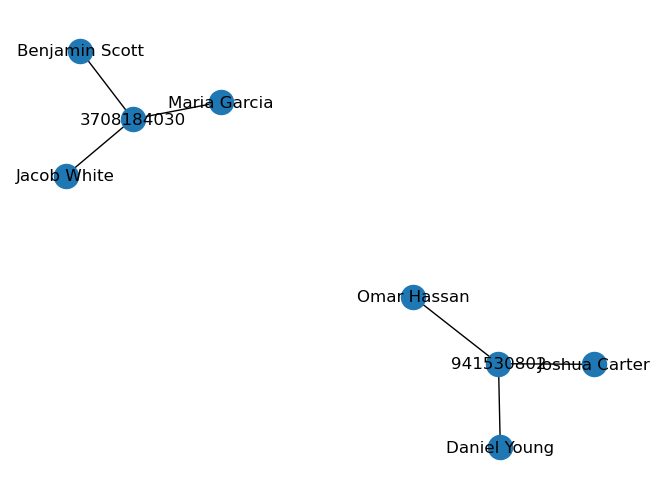

In [21]:
# Let's now look at Annie. 
referenceAuthor2 = authors[3] 
referenceAuthor2_papers = searchAuthorPapers(_df, referenceAuthor2)
referenceAuthor2_graph = create_graph(referenceAuthor2_papers)
show_graph(referenceAuthor2_graph)

In [22]:
# referenceAuthor2 is a part of two papers -- but we should still see their gender factor for each paper
calculateDIndex(referenceAuthor2, 
                referenceAuthor2_papers, 
                referenceAuthor2_graph, 
                baseNationalityBonus=0, 
                baseSpecializationFactor=0, 
                print_factors = True
               )

pub.941530802
Gender Factor: 3
Nationality Factor: 0
Specialization Factor: 0
pub.3708184030
Gender Factor: 2
Nationality Factor: 0
Specialization Factor: 0


2

In [24]:
# In herpaper with referenceAuthor1 has a gender factor of three
# This makes sense as in terms of equalizing each feature's representation referenceAuthor1 will only need to appear 1 time, as there are two other males
# On the other hand, referenceAuthor2's feature (female) needs to be represented 3 times in order to balance each feature's perspective in the paper

## Categorical Feature Examples :
Definitions Examples: Feature - Nationality, Category - Country

Here we include two separate examples. 
One is a "is not" example. It is similar to a binary calculation as we take all the categories for each feature and determine if the collaborators category for that feature "is not" the same as the reference authors category for that feature. 

The other is a weighted calculation. 
This involves giving certain categories more or less weight within a single feature, allowing for greater customization. 

For example English speakers might need to be rewarded less relative to non-English speakers for fairness. (only example, not neccessarily true)
Another way to not target English-born speakers is to use the English Proficiency Index (EPI - mentioned earlier) to award those who learn English to collaborate globally for their extra effort.
For simplicity we will only apply the weight to a single category. 

Since relative diversity takes the reciprocal of a proportion it is a bit counterinutitive on how the weightage should be applied. 
For example if you had 3 US natives : 1 foreigner, if we made the US valued at 0.5, then their sum would be 1.5. 
1/1.5 is significantly smaller than 1/3. Taking the reciprocal the foreigner now gets a value of 3/2 rounding to 2, instead of 3/1 which is 3. It also makes the US natives more valuable for the same reason. For simplicity the function by default takes the reciprocal of the proportion you enter. So if you want US native-speakers to be valued half as much you can put 0.5, but it is being applied as 2.0 

In [23]:
categorical_example_authors = collectAuthorsOfOnePaper(_df, "pub.1156792011")

In [25]:
for author in categorical_example_authors: 
    author.display()

Author: Priya Patel from Bangalore, India (female, Engineering)
Author: Michael Anderson from Scranton, United States (male, Social Science)
Author: James Miller from Scranton, United States (male, Healthcare)
Author: John Wilson from Scranton, United States (male, Computer Science)


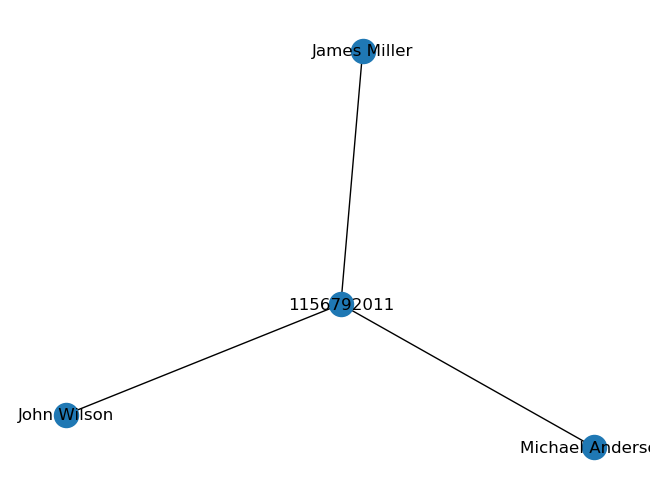

In [26]:
# Here we have three people from the US and one from India. 
categoricalRefAuthor = categorical_example_authors[0] 
categoricalRefAuthor_papers = searchAuthorPapers(_df, categoricalRefAuthor)
categoricalRefAuthor_graph = create_graph(categoricalRefAuthor_papers)
show_graph(categoricalRefAuthor_graph)

In [27]:
calculateDIndex(categoricalRefAuthor, 
                categoricalRefAuthor_papers, 
                categoricalRefAuthor_graph, 
                baseGenderFactor=0,
                baseSpecializationFactor=0, 
                categoricalWeights=None,
                print_factors=True
               )

pub.1156792011
Gender Factor: 0
Nationality Factor: 8
Specialization Factor: 0


8

In [28]:
categoricalWeights = {
    "nationality" : {"US" : 0.5} # If the categorical weight is unspecified defaults to 1. Here we give half value to English-speakers.
}
calculateDIndex(categoricalRefAuthor, 
                categoricalRefAuthor_papers, 
                categoricalRefAuthor_graph, 
                baseGenderFactor=0,
                baseSpecializationFactor=0, 
                categoricalWeights=categoricalWeights, 
                defaultReciprocal=True, #By default take the reciprocal of the entered categorical weight.
                print_factors=True
               )
# Now we can see her index nearly doubles, and that is directly from every other US author doubling in size, making her relative diversity greater.

pub.1156792011
Gender Factor: 0
Nationality Factor: 14
Specialization Factor: 0


14

### Summary

So far we have exemplified how the different features are accounted for using relative diversity, and the customization that can be achieved with different weightages. Hopefully you are already seeing the potential for expansion and the addition of new features. 
While not explicitly covered, you may have noticed that the more features we add, and the more potential categories within those features, can greatly increase the scale of the overall index. To handle this we added baseFactors. In this way you can try to achieve some level of weightage across features as well. In our examples we set some to zero in order to focus on one feature at a time. You can also experiment with fractional or negative values as well.

In these examples we look at one paper and one feature. In reality authors have multiple papers, multiple collaborators across the papers, and multiple features all at once. In the following examples we take a look at these more complex cases, focused on the results. Just remember everything comes up from this design: <br>
Collaborator Features => Feature Factor (Relative Diversity) => Paper Index => D-index 

### Cross-Paper Example: 

As we progress towards handling multiple papers an important issue arises. 
What if people try to abuse our scoring system. 
By choosing to handle relative diversity using tangible features, we fail to recognize intellectual diversity. 

What we mean by this is that the same group of diverse authors can work multiple times to boost their d-index score, without ever introducing new ideas. 

We handle this with our cross-paper features, as outlined above in Determing the index...

In [29]:
crossPaperExampleList = collectAuthorsOfOnePaper(_df, "pub.1123345821")
for author in crossPaperExampleList: 
    author.display()

Author: Adam Smith from Rome, Italy (male, Healthcare)
Author: Emily Johnson from Havana, Cuba (female, Computer Science)
Author: Robert Brown from New York City, United States (male, Engineering)
Author: Maria Garcia from Mexico City, Mexico (female, Social Science)
Author: David Williams from New York City, United States (male, Healthcare)
Author: Sophia Davis from New York City, United States (female, Computer Science)


In [30]:
crossPaperRefAuthor = crossPaperExampleList[0]
crossPaperRefAuthor_papers = searchAuthorPapers(_df, crossPaperRefAuthor)

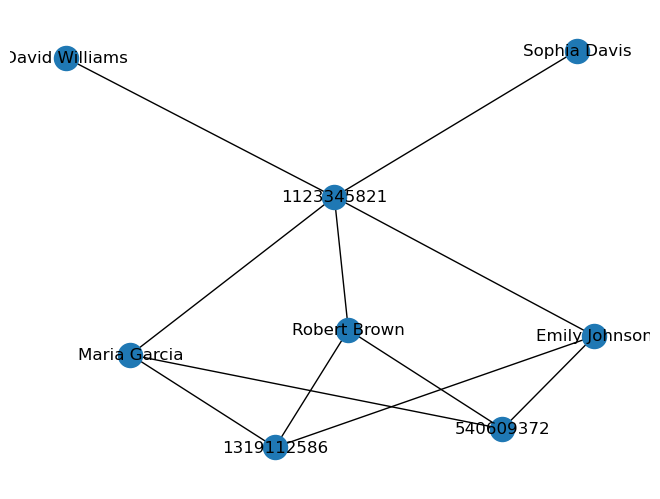

In [31]:
crossPaperRefAuthor_graph = create_graph(crossPaperRefAuthor_papers) 
show_graph(crossPaperRefAuthor_graph)

In [32]:
# For reference let's get crossPaperRefAuthor's d-index without accounting for repeated authors
calculateDIndex(crossPaperRefAuthor, crossPaperRefAuthor_papers, crossPaperRefAuthor_graph, crossPaper=False)

31

In [33]:
# It looks like crossPaperRefAuthor is with the same three authors many times
# Let's see what it is with accounting for repeated authors
calculateDIndex(crossPaperRefAuthor, crossPaperRefAuthor_papers, crossPaperRefAuthor_graph, crossPaper=True, minRepeats = 2, repeatCost = 0.5)

23

In [ ]:
# If you would like to trace the math yourself

In [49]:
# Without cross paper calculations
calculateDIndex(crossPaperRefAuthor, crossPaperRefAuthor_papers, crossPaperRefAuthor_graph, crossPaper=False, print_factors=True)

pub.1123345821
Gender Factor: 2
Nationality Factor: 24
Specialization Factor: 8
pub.1319112586
Gender Factor: 2
Nationality Factor: 16
Specialization Factor: 12
pub.540609372
Gender Factor: 2
Nationality Factor: 16
Specialization Factor: 12


31

In [50]:
# With cross paper calculations
calculateDIndex(crossPaperRefAuthor, crossPaperRefAuthor_papers, crossPaperRefAuthor_graph, crossPaper=True, minRepeats = 2, repeatCost = 0.5, print_factors=True)

pub.1123345821
Gender Factor: 2
Nationality Factor: 16
Specialization Factor: 8
pub.1319112586
Gender Factor: 2
Nationality Factor: 8
Specialization Factor: 12
pub.540609372
Gender Factor: 2
Nationality Factor: 8
Specialization Factor: 12


23

In [52]:
# for manual trace, original source of information:
show_author_publications(crossPaperRefAuthor_papers, crossPaperRefAuthor_graph)

pub.1123345821
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States (male, Engineering)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico (female, Social Science)
Number of shared occurences: 3
Author: Charles Boyle from New York City, United States (male, Healthcare)
Number of shared occurences: 1
Author: Gina Linetti from New York City, United States (female, Computer Science)
Number of shared occurences: 1

pub.1319112586
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States (male, Engineering)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico (female, Social Science)
Number of shared occurences: 3

pub.540609372
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Number of shared occurences: 3
Author: Ray Holt from New York City, Uni

# ============================================================================

# Examples (Old - comments may be wrong with new updates)

Examples are drawn from a sample csv file, which models its columns after collected data from the Dimensions database. Information extracted from the database should consist of these columns.

After extracting data from Dimensions you must apply this function to the output: 
.as_dataframe_authors_affiliations() <br>
Further documentation linked here: 
[Dimcli Docs](https://api-lab.dimensions.ai/cookbooks/7-researchers/Researchers-Search-tips-V2.html )

The sample csv mimics the output, but does not use real researchers. 
We compiled a dataframe consisting of many television characters, using actors working in multiple shows as cross-paper authors, along with mixing up some actors to generate our examples.

Note: 
This is just a conceptual demonstration of the potential for a d-index to encourage new collaboration new research. By no means is this conclusive or accurate. New ideas and features will have to be considered prior to real implementation

### Example 1
This example demonstrates how two authors can have the same gender and nationality factor in their shared paper from shared characteristics
It also shows how the nationality and gender factor work with different genders and nationalities. 

In [16]:
authorList = collectAuthorsOfOnePaper(_df, "pub.3708184030")

In [17]:
for author in authorList: 
    author.display()

Author: Bo Jack from Toronto, Canada (male, Engineering)
Author: Jessie Pinkman from Emmett, United States (male, Social Science)
Author: Annie Nguyen from Los Angeles, United States (female, Computer Science)
Author: Rosa Diaz from Houston, United States (female, Social Science)


In [18]:
x = searchAuthorPapers(_df, authorList[2]) # Find all papers for Annie Nguyen

In [19]:
G = create_graph(x)

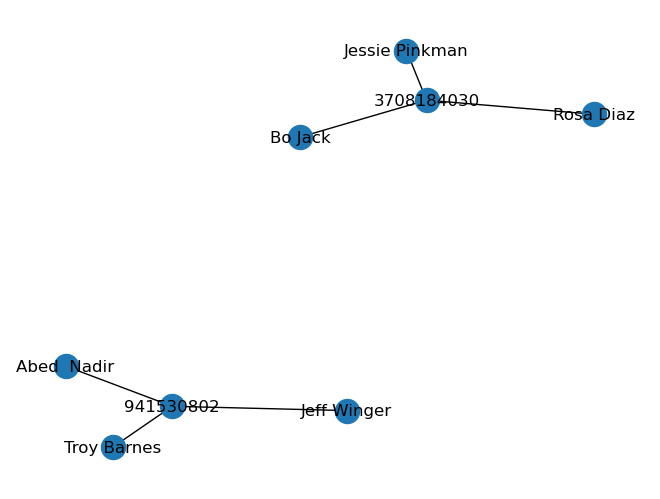

In [20]:
show_graph(G)
# Here we can see that Annie is in two papers, however none of her collaborators repeat

In [21]:
y = searchAuthorPapers(_df, authorList[3]) # This is the dictionary for Rosa Diaz

In [22]:
G2 = create_graph(y)

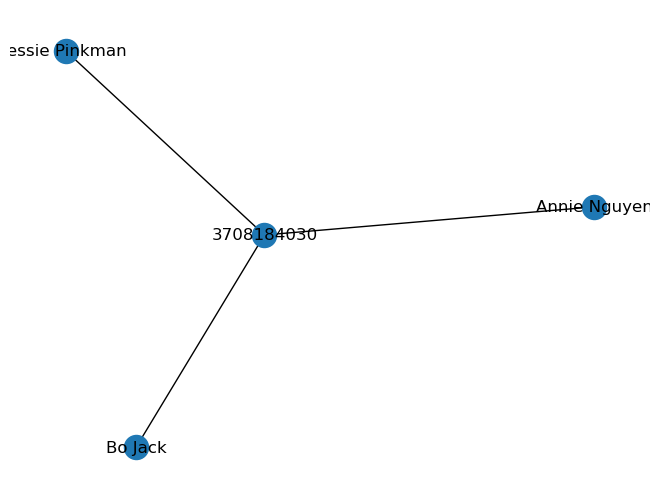

In [23]:
show_graph(G2) # Here you can see she is part of the one paper with Annie, and no other papers

In [24]:
annie_index = calculateDIndex(authorList[2], x, G, print_factors=True)

pub.941530802
Gender Factor: 3
Nationality Factor: 6
Specialization Factor: 12
pub.3708184030
Gender Factor: 2
Nationality Factor: 2
Specialization Factor: 9


In [25]:
print(authorList[2].getName() + "'s D-Index: "+ str(annie_index))

Annie Nguyen's D-Index: 17


In [26]:
rosa_index = calculateDIndex(authorList[3], y, G2, print_factors=True)

pub.3708184030
Gender Factor: 2
Nationality Factor: 2
Specialization Factor: 6


In [27]:
print(authorList[3].getName() + "'s D-Index: "+ str(rosa_index))

Rosa Diaz's D-Index: 10


In [28]:
show_author_publications(x, G)

pub.941530802
Author: Abed  Nadir from Jerusalem, Palestine (male, Engineering)
Number of shared occurences: 1
Author: Troy Barnes from Atlanta, United States (male, Social Science)
Number of shared occurences: 1
Author: Jeff Winger from Rome, Italy (male, Healthcare)
Number of shared occurences: 1

pub.3708184030
Author: Bo Jack from Toronto, Canada (male, Engineering)
Number of shared occurences: 1
Author: Jessie Pinkman from Emmett, United States (male, Social Science)
Number of shared occurences: 1
Author: Rosa Diaz from Houston, United States (female, Social Science)
Number of shared occurences: 1



In [29]:
show_author_publications(y, G2)

pub.3708184030
Author: Bo Jack from Toronto, Canada (male, Engineering)
Number of shared occurences: 1
Author: Jessie Pinkman from Emmett, United States (male, Social Science)
Number of shared occurences: 1
Author: Annie Nguyen from Los Angeles, United States (female, Computer Science)
Number of shared occurences: 1



### Example 2
This example shows how authors of the same paper can have different indexes just based on their perspective within the paper
All of these authors are only linked to this paper.
Due to the fact there is one female from a foreign country her perspective needs to be multiplied greatly to achieve equal representation. 
On the other hand, three of four authors are males from the US, therefore their perspectives are considered similar.

In [30]:
authorList = collectAuthorsOfOnePaper(_df, "pub.1156792011")

In [31]:
for author in authorList:
    author.display()

Author: Kelly Kapoor from Bangalore, India (female, Engineering)
Author: Michael Scott from Scranton, United States (male, Social Science)
Author: Jim Halpert from Scranton, United States (male, Healthcare)
Author: Dwight  Schrute from Scranton, United States (male, Computer Science)


In [32]:
x = searchAuthorPapers(_df, authorList[0])

In [33]:
G = create_graph(x)

In [34]:
index = calculateDIndex(authorList[0], x, G)

In [35]:
print(index)

23


In [36]:
y = searchAuthorPapers(_df, authorList[1])

In [37]:
G2 = create_graph(y)

In [38]:
index2 = calculateDIndex(authorList[1], y, G2)

In [39]:
print(index2)

15


### Example 3

This example explores the relationship of one author who has collaborated with other authors across three papers. This will represent the cross-paper feature of number of shared occurences.

You can see the D-index of the author drops 4 points by 

In [40]:
# Compile list of authors from selected publication
authorList = collectAuthorsOfOnePaper(_df, "pub.1123345821", start_point=0) 

In [41]:
for author in authorList: 
    author.display()

Author: Jake Peralta from Rome, Italy (male, Healthcare)
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Author: Ray Holt from New York City, United States (male, Engineering)
Author: Rosa  Diaz from Mexico City, Mexico (female, Social Science)
Author: Charles Boyle from New York City, United States (male, Healthcare)
Author: Gina Linetti from New York City, United States (female, Computer Science)


In [42]:
# Creates dictionary of people Jake Peralta has worked with across all of the papers he is in in the dataframe
x = searchAuthorPapers(_df, authorList[0]) 

In [43]:
G = create_graph(x) # creates Graph from dictionary

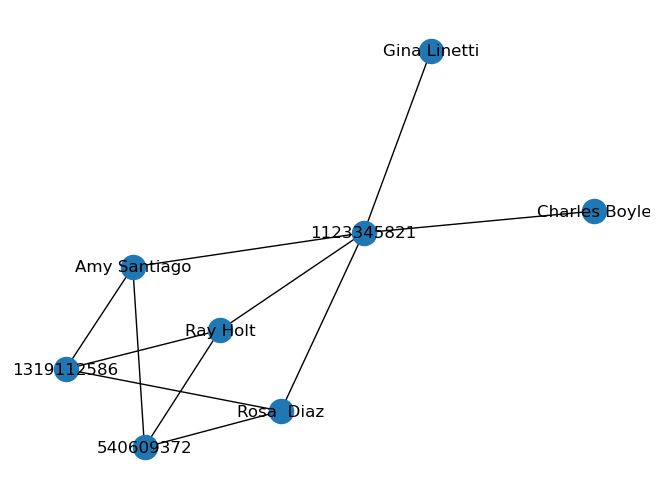

In [46]:
# As you can see, there is a group of authors that appear to have shared appearances in three papers, 
# along with two outliers added in a third paper
show_graph(G)

In [47]:
index = calculateDIndex(authorList[0], x, G, minRepeats=2, print_factors=True) # Calculate index for Jake 

pub.1123345821
Gender Factor: 2
Nationality Factor: 20
Specialization Factor: 8
pub.1319112586
Gender Factor: 2
Nationality Factor: 12
Specialization Factor: 12
pub.540609372
Gender Factor: 2
Nationality Factor: 12
Specialization Factor: 12


In [48]:
print(authorList[0].getName() + "'s D-Index: "+ str(index))

Jake Peralta's D-Index: 27


In [49]:
# Calculate index without decreasing the authors added value for repeat occurences
index = calculateDIndex(authorList[0], x, G, minRepeats=2, crossPaper=False, print_factors=True) 

pub.1123345821
Gender Factor: 2
Nationality Factor: 24
Specialization Factor: 8
pub.1319112586
Gender Factor: 2
Nationality Factor: 16
Specialization Factor: 12
pub.540609372
Gender Factor: 2
Nationality Factor: 16
Specialization Factor: 12


In [50]:
print(authorList[0].getName() + "'s D-Index without crossPaperFeatures: "+ str(index))

Jake Peralta's D-Index without crossPaperFeatures: 31


In [51]:
show_author_publications(x, G) # Use to fact-check the math

pub.1123345821
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States (male, Engineering)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico (female, Social Science)
Number of shared occurences: 3
Author: Charles Boyle from New York City, United States (male, Healthcare)
Number of shared occurences: 1
Author: Gina Linetti from New York City, United States (female, Computer Science)
Number of shared occurences: 1

pub.1319112586
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Number of shared occurences: 3
Author: Ray Holt from New York City, United States (male, Engineering)
Number of shared occurences: 3
Author: Rosa  Diaz from Mexico City, Mexico (female, Social Science)
Number of shared occurences: 3

pub.540609372
Author: Amy Santiago from Havana, Cuba (female, Computer Science)
Number of shared occurences: 3
Author: Ray Holt from New York City, Uni